<a href="https://colab.research.google.com/github/EvgenySkvortsov/Scripts/blob/main/Script_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Скрипт для предобработки датасета (v.4)
### Реализовано:

*   загрузка PDF файла
*   извлечение изображений
*   устранение наклона текста
*   распознавание текста бюллетеня и извлечение данных из нижнего колонтитула
*   извлечение всех таблиц из бюллетеней
*   отбор таблиц с результатами голосования и запись в отдельные файлы
*   сведение полученных данных в таблицу

### Не реализовано:
*   повышение резкости или даже "мясистости" объектов на изображении для более корректного вырезания таблиц
*   устранение шума (не целесообразно после преобразования в ч/б формат)
*   распознавание перевернутых листов

In [ ]:
# Загрузка и подключение библиотек для преобразования страниц PDF файла в изображения
!apt-get install -y poppler-utils
!pip install pdf2image
from pdf2image import convert_from_path

# Подключение библиотек для реализации корректировки угла наклона текста на изображениях
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter

# Подключение библиотек для извлечения таблиц из изображений
!pip install img2table
from img2table.document import Image

# Подключение библиотек для распознавания текста, поворота страниц и вывода изображений
!apt install tesseract-ocr
!apt install tesseract-ocr-rus
!pip install pytesseract
import pytesseract
from PIL import Image as PILImage
from PIL import ImageFilter
import matplotlib.pyplot as plt

# Функции операционной системы
import os
import shutil
import glob

# Работа с таблицами
import pandas as pd

# Вывод сообщений на экран
from google.colab import output

# Вывод предупреждений на экран
import warnings

# Работа с Progress bar
import time
from time import sleep
from tqdm import tqdm

# Подключение google disc для загрузки датасета
from google.colab import drive
drive.mount('/content/drive')

# Очистка экрана
output.clear()

In [ ]:
# Текущая папка
os.chdir('/content')

# Создание каталогов /content/dataset и /content/dataset/images, если таковых не существует
if not os.path.isdir('dataset'):
     os.mkdir('dataset')
os.chdir('/content/dataset')
if not os.path.isdir('images'):
     os.mkdir('images')
os.chdir('/content/dataset/')
if not os.path.isdir('lines'):
     os.mkdir('lines')

# Копирование датасета из каталога Google Disc в каталог /content/dataset
shutil.copy('/content/drive/MyDrive/Internship_1/Dataset/Sadovaya_29.pdf', '/content/dataset/')


'/content/dataset/Sadovaya_29.pdf'

In [74]:
# Очистка папок с изображениями (актуально на время экспериментов)
files = glob.glob('/content/dataset/images/*')
for l in files:
    os.remove(l)

files = glob.glob('/content/dataset/lines/*')
for l in files:
    os.remove(l)

# Извлечение страниц из PDF файла в разрешении 150dpi, формат изображения задается строковой переменной [f]
f = 'tiff'
images = convert_from_path(f'/content/drive/MyDrive/Internship_1/Dataset/Sadovaya_29.pdf', 150, fmt=str(f), first_page=0, last_page=9) # Определенные страницы first_page=0, last_page=2
for i, image in enumerate(images):
    image.save(f'/content/dataset/images/img_{i+1}.{f}')

# Вывод количества страниц в датасете
print(f'Количество страниц в датасете: {len(os.listdir(path="/content/dataset/images/"))}')

Количество страниц в датасете: 9


In [ ]:
# Функция, устраняющая наклон текста на изображениях
def correct_skew(image, delta, limit):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

In [ ]:
# Функция для вывода изображения на экран
def show_img(i, w, h, title):

    img = PILImage.open(i)
    fig = plt.figure(figsize=(w, h))
    ax = fig.add_subplot()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)
    plt.title(title)

    plt.show()
    print()

In [ ]:
# Запрет на вывод предупреждений на экран
warnings.filterwarnings('ignore')

# Демонстрация устранения наклона текста на изображении
cur_img = '/content/dataset/images/img_1.tiff'
w, h = 10, 15 # Ширина и высота изображения
show_img(cur_img, w, h, 'Исходное изображение')

# Корректировка угла наклона текста
image = cv2.imread(cur_img)
angle, rotated = correct_skew(image, 0.5, 5)
cv2.imwrite(cur_img, rotated)
cv2.waitKey()

show_img(cur_img, w, h, 'Корректированное изображение')

In [75]:
# Запрет на вывод предупреждений на экран
warnings.filterwarnings('ignore')

# Создание таблицы с заголовками. В нее будут записаны данные из колонтитула страницы бюллетеня
df = pd.DataFrame(columns=['Номер бюллетеня','Номер страницы','Всего страниц'])

# Перебор изображений и корректировка угла наклона текста
for i in os.listdir('/content/dataset/images/'):
    image = cv2.imread(f'/content/dataset/images/{i}')
    angle, rotated = correct_skew(image, 0.5, 5)
    cv2.imwrite(f'/content/dataset/images/{i}', rotated)
    cv2.waitKey()

    # Извлечение текста из файла изображения
    text = pytesseract.image_to_string(PILImage.open(f'/content/dataset/images/{i}'), lang='rus')

    # В конце текста спецсимвол и перенос строки. Не особо то и нужны. Уберем.
    text = text[:-2]

    # Извлекаем необходимые данные из колонтитула страницы бюллетеня
    bull_number = text[-28:]
    page_number = text[-46]
    total_page = text[-41]

    # Добавление в таблицу строки с данными из колонтитула страницы бюллетеня
    df.loc[len(df.index )] = [bull_number, page_number, total_page]

    # ------------------------------------------------------------------
    # Повышение резкости изображения, иначе обрезает таблицы, как попало
    # ------------------------------------------------------------------
    # Не особо рабочий код
    #img = PILImage.open(f'/content/dataset/images/{i}')
    #sharp_img = img.filter(ImageFilter.SHARPEN)
    #sharp_img.save(f'/content/dataset/images/{i}')

    # Еще один вариант повышения резкости
    # Тут нужно поиграться с ядром свертки
    # Даже не то, чтобы резче сделать, а "нарастить мяса" на объекты на изображении
    # "Жиденькие" границы вырезалка плохо распознает и вырезает лишь фрагмент таблицы по более четким границам
    image = cv2.imread(f'/content/dataset/images/{i}')
    # То самое ядро и оно не обязательно должно быть размером 3х3
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, 1],
                       [-1, -1, -1]])
    sharpened_image = cv2.filter2D(image, -1, kernel)
    cv2.imwrite(f'/content/dataset/images/{i}', sharpened_image)

    # ------------------------------------------------------------------

    # Загружаем страницу бюллетеня в библиотеку img2table
    img = Image(f'/content/dataset/images/{i}', detect_rotation=True)

    # Обнаружение таблиц на изображении
    img_tables = img.extract_tables()

    # Список координат обнаруженных таблиц ()
    img_tables

    img = PILImage.open(f'/content/dataset/images/{i}')

    # Извлечение списка координат обнаруженных таблиц на изображении
    # (в лучших традициях немецкого документального кинематографа,
    # потому что не знаю, как правильно это сделать)
    # Там мудреный формат данных. Пришлось конвертировать в строки,
    # а из них уже вытаскивать данные координат.
    # На страничке проекта img2table в GitHub есть код для грамотного извлечения
    # списка координат, но разобраться не смог. Может получится у кого.
    # https://github.com/xavctn/img2table
    crd_list = []
    for i in img_tables:
        i_str = str(i)
        list_crd_str = i_str[33: i_str.find(')')].replace(',', '').split()
        list_crd_int = list(map(int, list_crd_str))
        crd_list.append(list_crd_int)

    # Вырезаем таблицы по координатам
    border_size = 3 # Толщина добавочной каемки вокруг таблицы
    bull_number_2 = bull_number.replace('/', '-') # Извлечение данных для имени файла из текста на странице бюллетеня
    count = 1 # Счетчик обнаруженных табличек с результатами голосования
    for i in crd_list: # Перебираем список с координатами таблиц
        cropped = img.crop((i[0]-border_size, i[1]-border_size, i[2]+border_size, i[3]+border_size)) # Вырезаем таблицы по координатам
        if page_number == '1' and i[1] < 820: # Отсекаем пространство с ненужной информацией на 1-ой странице бюллетеня
            continue

        # Исторический момент - вожделенная табличка с результатами голосования сохраняется на диск
        cropped.save(f'/content/dataset/lines/{bull_number_2} ({page_number}-{count}).tiff')
        count += 1

In [ ]:
# Вывод таблицы со страницами бюллетений на экран
df

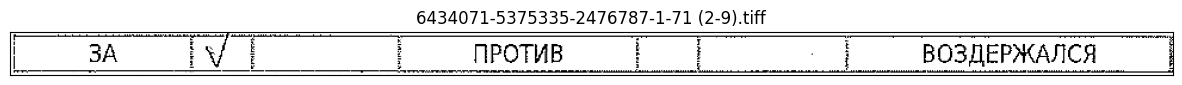

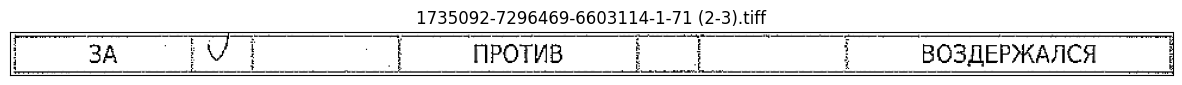

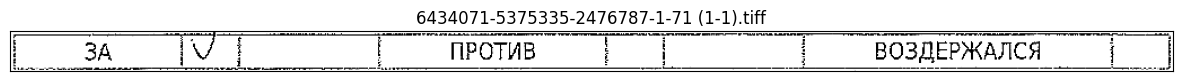

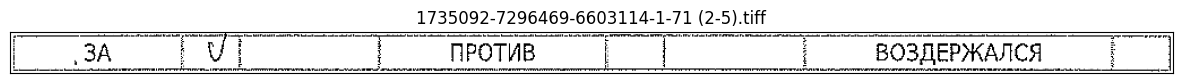

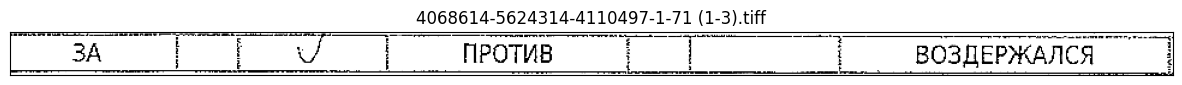

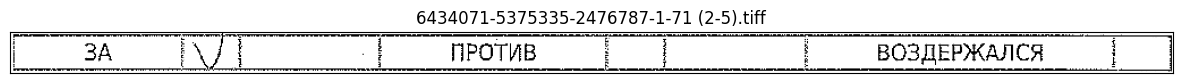

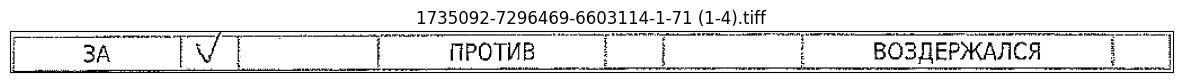

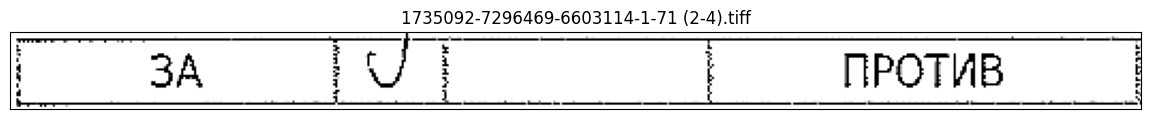

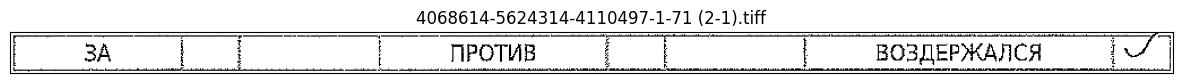

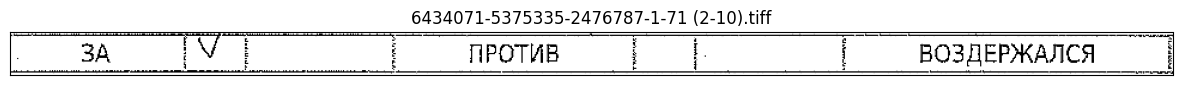

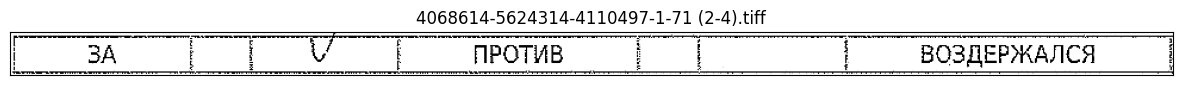

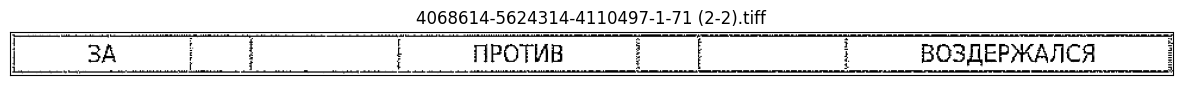

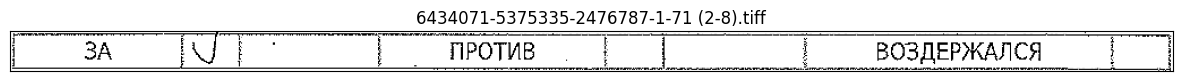

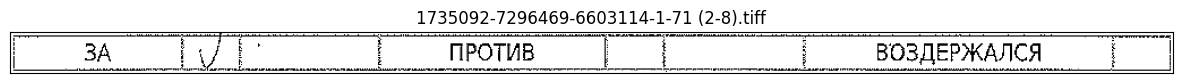

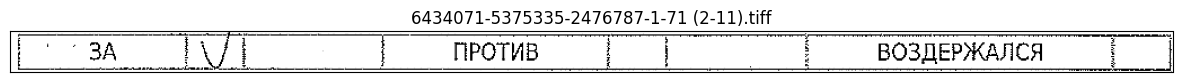

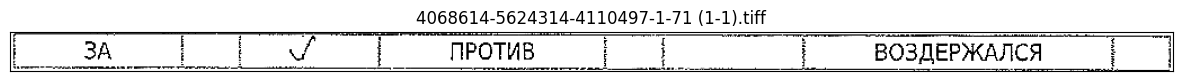

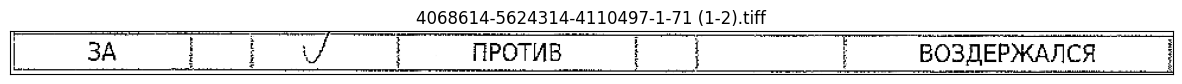

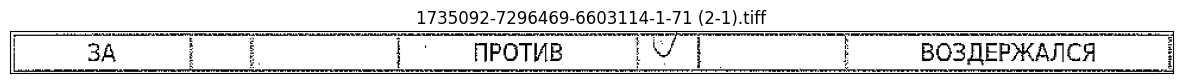

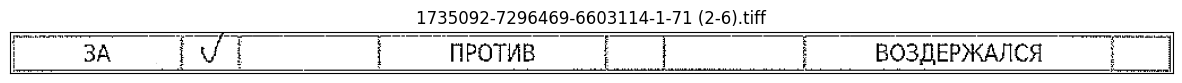

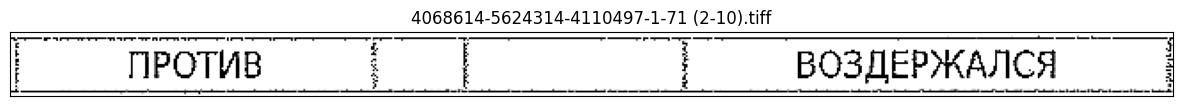

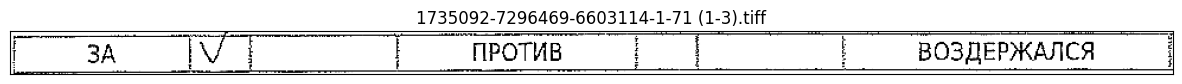

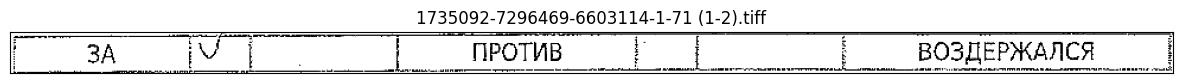

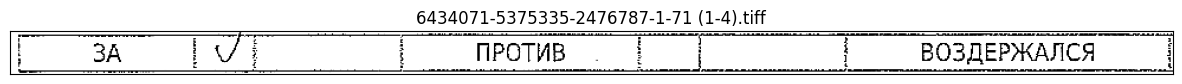

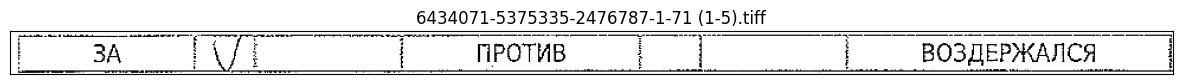

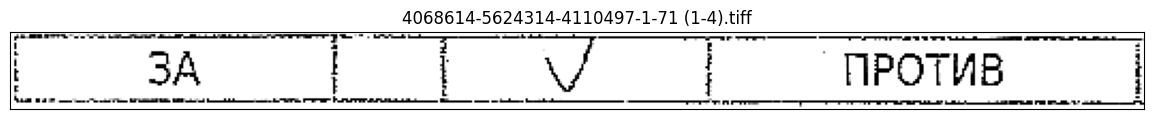

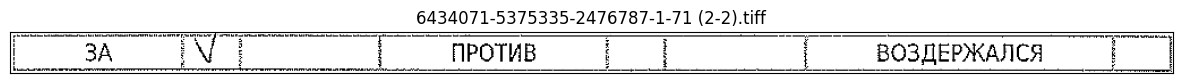

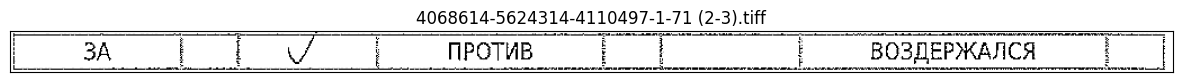

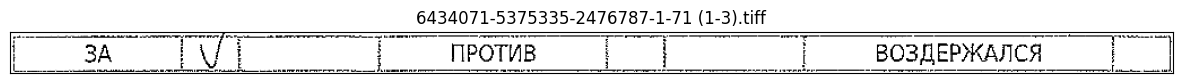

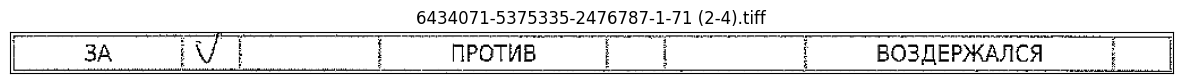

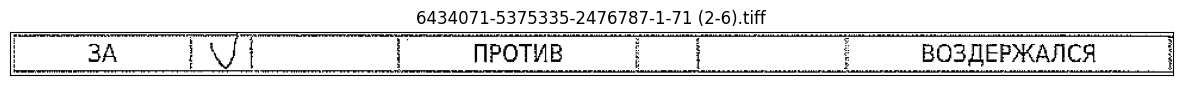

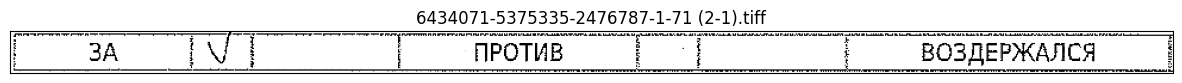

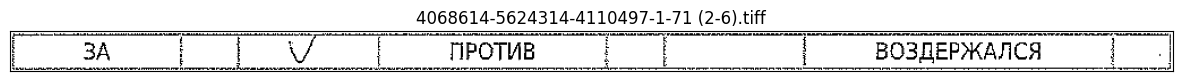

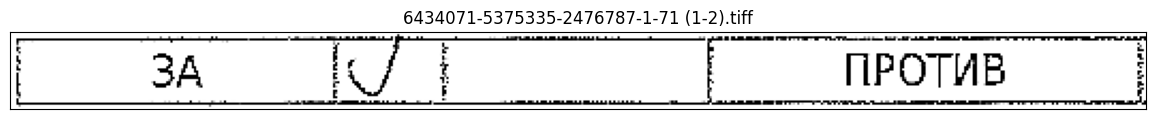

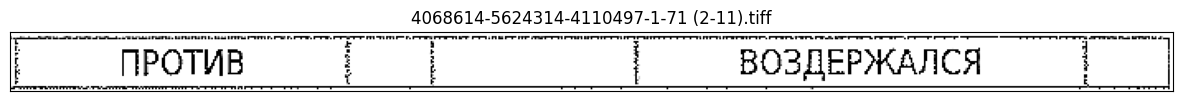

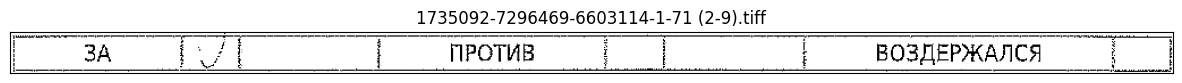

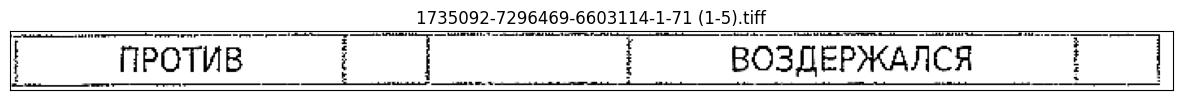

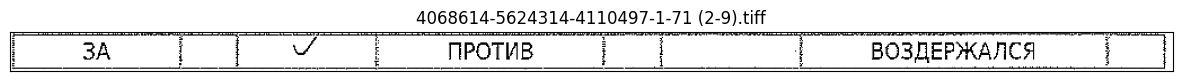

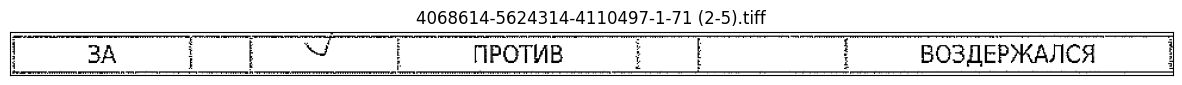

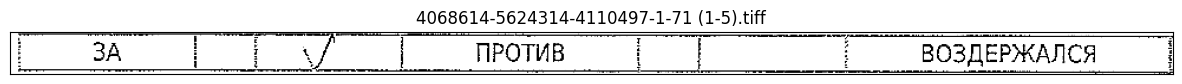

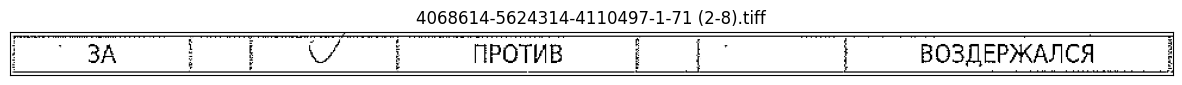

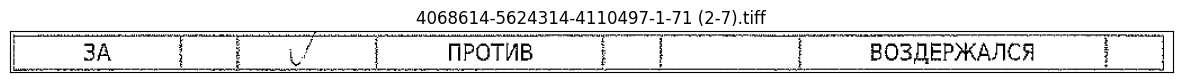

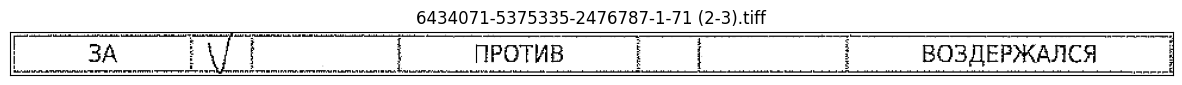

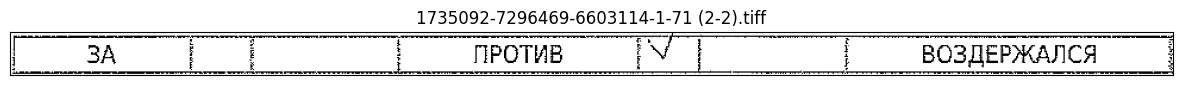

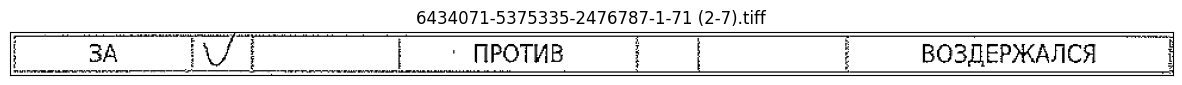

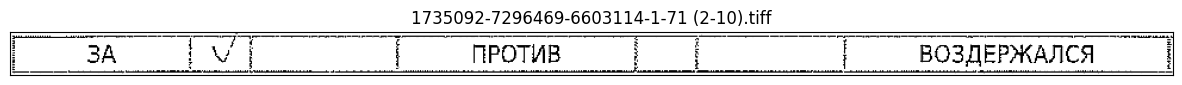

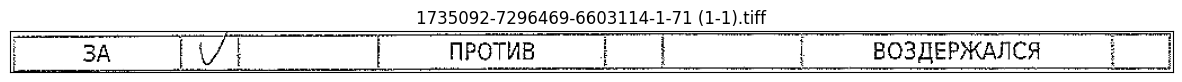

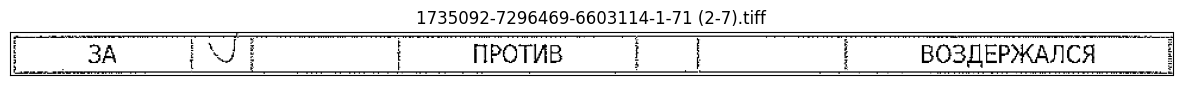

In [76]:
# Вывод извлеченных таблиц на экран
for i in os.listdir('/content/dataset/lines/'):
    show_img(f'/content/dataset/lines/{i}', 15, 1, i)

In [ ]:
# Архивация папки /content/dataset/lines/ с извлеченными таблицами
# Потом можно скачать через браузер
!zip -r /content/dataset/lines/voting_results.zip /content/dataset/lines/*.tiff